In [1]:
# Importing all required libraries for the assignment
from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
import pandas as pd
import re
import pyspark.sql.functions as F
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from operator import add
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import substring, length, col, expr
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pandas.plotting import scatter_matrix
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Part 1: Data preparation and exploration

## 1.1 Create spark config

In [2]:
#Create spark configuration with all threads available on VM and with name as "Assingment-1"
spark_conf = SparkConf().setMaster("local[*]").setAppName("Assignment-2A").set("spark.sql.files.maxPartitionBytes",33554432)
#Creating spark context from the configuration
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## 1.2 Defining the Schema and reading the data

In [3]:
#Schema for process activity
processActivityFields = [StructField("ts",IntegerType(),True),
         StructField("PID",IntegerType(),True),
         StructField("TRUN",IntegerType(),True),
         StructField("TSLPI",IntegerType(),True),
         StructField("TSLPU",IntegerType(),True),
         StructField("POLI",StringType(),True),
         StructField("NICE",IntegerType(),True),
         StructField("PRI",IntegerType(),True),
         StructField("RTPR",IntegerType(),True),
         StructField("CPUNR",IntegerType(),True),
         StructField("Status",StringType(),True),
         StructField("EXC",IntegerType(),True),
         StructField("State",StringType(),True),
         StructField("CPU",DoubleType(),True),
         StructField("CMD",StringType(),True),
         StructField("attack",IntegerType(),True),
         StructField("type",StringType(),True)]
processActivitySchema = StructType(processActivityFields)
#Schema for memory activity
memoryActivityFields = [StructField("ts",DoubleType(),True),
                       StructField("PID",DoubleType(),True),
                       StructField("MINFLT",StringType(),True),
                       StructField("MAJFLT",StringType(),True),
                       StructField("VSTEXT",StringType(),True),
                       StructField("VSIZE",DoubleType(),True),
                       StructField("RSIZE",StringType(),True),
                       StructField("VGROW",StringType(),True),
                       StructField("RGROW",StringType(),True),
                       StructField("MEM",DoubleType(),True),
                       StructField("CMD",StringType(),True),
                       StructField("attack",DoubleType(),True),
                       StructField("type",StringType(),True)]
memoryActivitySchema = StructType(memoryActivityFields)

In [4]:
#Read Data and get number of partition
df_process = spark.read.csv("Data_Ass2/linux_process_*.csv",header=True,sep=",",schema=processActivitySchema)
df_process.createOrReplaceTempView("Process_data_1")
df_process.rdd.getNumPartitions()

4

In [5]:
#Read Data and get number of partition
df_memory = spark.read.csv("Data_Ass2/linux_memory_*.csv",header=True,sep=",",schema=memoryActivitySchema)
df_memory.createOrReplaceTempView("Memory_data_1")
df_memory.rdd.getNumPartitions()

4

In [6]:
print('Number of records in process file %s' %(df_process.count()))
print('Number of records in memory file %s' %(df_memory.count()))

Number of records in process file 1927968
Number of records in memory file 2000000


In [7]:
#Check for nulls
df_process.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df_process.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



In [8]:
#Check for nulls
df_memory.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df_memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [11]:
#Wrangling the data into proper format for the following columns
#By chekcing for condition we can change to value to its corresponsing corerct form.
df_memory = df_memory.withColumn('MINFLT',\
when(col("MINFLT").contains('K'),expr('substring(MINFLT,1,length(MINFLT)-1)').cast('double')*1000)
.otherwise(col("MINFLT").cast('double')))

df_memory = df_memory.withColumn('MAJFLT',\
when(col("MAJFLT").contains('M'),expr('substring(MAJFLT,1,length(MAJFLT)-1)').cast('double')*1000000)
.otherwise(col("MAJFLT").cast('double')))

df_memory = df_memory.withColumn('VSTEXT',\
when(col("VSTEXT").contains('K'),expr('substring(VSTEXT,1,length(VSTEXT)-1)').cast('double')*1000)
.otherwise(col("VSTEXT").cast('double')))

df_memory = df_memory.withColumn('RSIZE',\
when(col("RSIZE").contains('K'),expr('substring(RSIZE,1,length(RSIZE)-1)').cast('double')*1000)
.when(col("RSIZE").contains('M'),expr('substring(RSIZE,1,length(RSIZE)-1)').cast('double')*1000000)        
.otherwise(col("RSIZE").cast('double')))

df_memory = df_memory.withColumn('VGROW',\
when(col("VGROW").contains(' '),regexp_replace(col("VGROW")," ","").cast('double'))
.when(col("VGROW").contains('K'),expr('substring(VGROW,1,length(VGROW)-1)').cast('double')*1000)
.otherwise(col("VGROW").cast('double')))

df_memory = df_memory.withColumn('RGROW',\
when(col("RGROW").contains('K'),expr('substring(RGROW,1,length(RGROW)-1)').cast('double')*1000)
.otherwise(col("RGROW").cast('double')))

In [12]:
df_memory.printSchema()

root
 |-- ts: double (nullable = true)
 |-- PID: double (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: double (nullable = true)
 |-- type: string (nullable = true)



In [13]:
#Caching Dataframes
df_process.cache()
df_memory.cache()

DataFrame[ts: double, PID: double, MINFLT: double, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: double, type: string]

In [14]:
#Get the categorical and numerical columns for process and memory
categoricalColProc = [x[0] for x in df_process.dtypes if x[1]=='string']
numericalColProc = [x[0] for x in df_process.dtypes if (x[1]=='int') | (x[1]=='float') | (x[1]=='double')]
categoricalColMem = [x[0] for x in df_memory.dtypes if x[1]=='string']
numericalColMem = [x[0] for x in df_memory.dtypes if (x[1]=='int') | (x[1]=='float') | (x[1]=='double')]

In [15]:
print("Categorical col for Process Activity: %s" % (categoricalColProc))
print("Numerical col for Process Activity: %s" % (numericalColProc))
print("Categorical col for Memory Activity: %s" % (categoricalColMem))
print("Numerical col for Memory Activity: %s" % (numericalColMem))

Categorical col for Process Activity: ['POLI', 'Status', 'State', 'CMD', 'type']
Numerical col for Process Activity: ['ts', 'PID', 'TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'EXC', 'CPU', 'attack']
Categorical col for Memory Activity: ['CMD', 'type']
Numerical col for Memory Activity: ['ts', 'PID', 'MINFLT', 'MAJFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'VGROW', 'RGROW', 'MEM', 'attack']


## 1.3 Exploration of the data

### Task 1.3.1 Basic types of attacks

In [16]:
df_process.groupby('attack').agg(F.count('attack').alias('Count')).toPandas()

,attack,Count
0,1,291364
1,0,1636604


In [17]:
df_memory.groupby('attack').agg(F.count('attack').alias('Count')).toPandas()

,attack,Count
0,0.0,1794377
1,1.0,205623


In [18]:
df_process.groupby('type').agg(F.count('type').alias('Count')).toPandas()

,type,Count
0,xss,17759
1,password,51409
2,scanning,38449
3,ddos,71603
4,normal,1636604
5,mitm,112
6,injection,41311
7,dos,70721


In [19]:
df_memory.groupby('type').agg(F.count('type').alias('Count')).toPandas()

,type,Count
0,password,26016
1,ddos,45689
2,normal,1794377
3,mitm,112
4,injection,58523
5,dos,75283


<p>

From the above tables we can see we have much more values of 0's(non-attack) as compared to 1's(attack). We also see the below observation:
    * Man in the middle is the least common attack seen
    * Majority our normal i.e non-attack.
    * The most common types of attack are are form of dos attack or injection
    
</p>

### Task 1.3.2 Statistical discovery of the data

In [20]:
df_process.select(numericalColProc).describe().toPandas()

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU,attack
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527299209388,0.1511249149363475
2,stddev,771350.0248109627,4987.784329320437,0.247825870904161,6.988459728531793,0.04421874419214597,8.40318986475207,22.624445062102893,0.0,1.5274047225903056,1.4619498567691878,0.13628943687184275,0.35817068774739264
3,min,1554216855,1007,0,0,0,0,0,0,0,0,0.0,0
4,max,1557593017,53080,12,70,21,20,139,0,5,127,4.02,1


In [21]:
df_memory.select(numericalColMem).describe().toPandas()

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,attack
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,987846.5873270865,46453.27415208986,4496.419966448755,23722.888664201997,984.4668735599995,483.17466254999994,0.003385165000001682,0.1028115
2,stddev,984463.3682899477,4887.313351921473,19229.610980642334,1.4842874238098994E7,658730.2051543018,9046.338093399043,1986383.1808735211,86174.82585202329,1491.4761059171788,0.010943425779985876,0.30371259701965325
3,min,1.554216855E9,1007.0,0.0,0.0,0.0,0.0,-9728.0,-9392000.0,0.0,0.0,0.0
4,max,1.558355716E9,53096.0,8050000.0,2.244E8,1.12E7,88040.0,2.244E8,1.116E7,98920.0,0.44,1.0


In [22]:
#Categorical values for Process
for col in [x for x in categoricalColProc if (x!='type')|(x!='attack')]:
    df_process.groupBy(col).agg(F.count('type').alias('Count')).sort('Count',ascending=False).show(10)

+----+-------+
|POLI|  Count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  Count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  Count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| Count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows

+---------+-------+
|     type|  Count|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scann

In [23]:
#Categorical values for Memory
for col in [x for x in categoricalColMem if (x!='type')|(x!='attack')]:
    df_memory.groupBy(col).agg(F.count('type').alias('Count')).sort('Count',ascending=False).show(10)

+----------+------+
|       CMD| Count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows

+---------+-------+
|     type|  Count|
+---------+-------+
|   normal|1794377|
|      dos|  75283|
|injection|  58523|
|     ddos|  45689|
| password|  26016|
|     mitm|    112|
+---------+-------+



### Task 1.3.3 Correlation matrix 

In [24]:
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)
    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

Text(0.5, 1.0, 'Correlation Matrix for Process Activites')

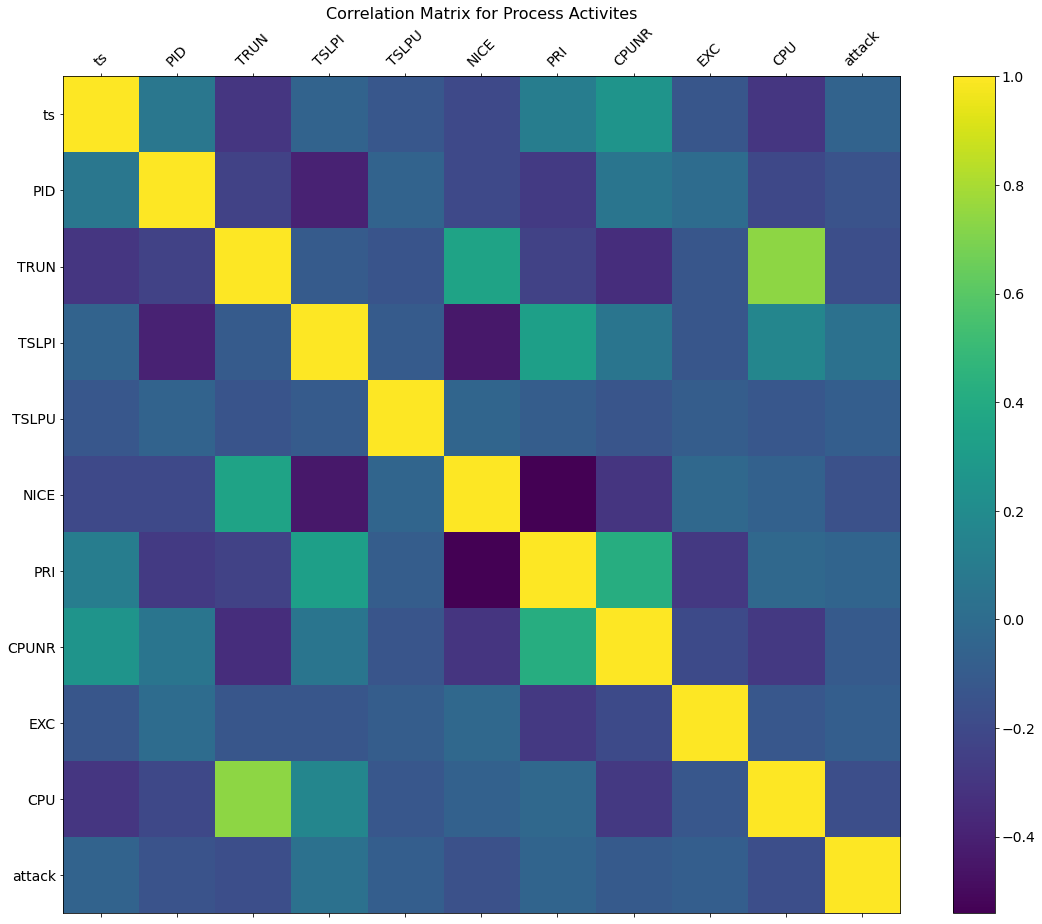

In [25]:
corr_matrix_proc = correlation_matrix(df_process.select([x for x in numericalColProc if x!='RTPR']),[x for x in numericalColProc if x!='RTPR'])
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix_proc.corr(), fignum=f.number)
plt.xticks(range(corr_matrix_proc.shape[1]), corr_matrix_proc.columns, fontsize=14, rotation=45)
plt.yticks(range(corr_matrix_proc.shape[1]), corr_matrix_proc.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for Process Activites', fontsize=16)

<p>
We can see that ts and PID have very high correlation with each other and some critical variables. However since ts is nothing but timestamp of the activity and PID is a unique ID, they have an inflated correlation due to the uniqueness of each entry. 
    
Asside from the above note following are some intresting correlation:

* CPU and TRUN are highly positively correlated
* NICE and TSLPI are highly negativly correlated
* PRI and CPUNR are postivly correlated.
</p>

Text(0.5, 1.0, 'Correlation Matrix for Memory Activities')

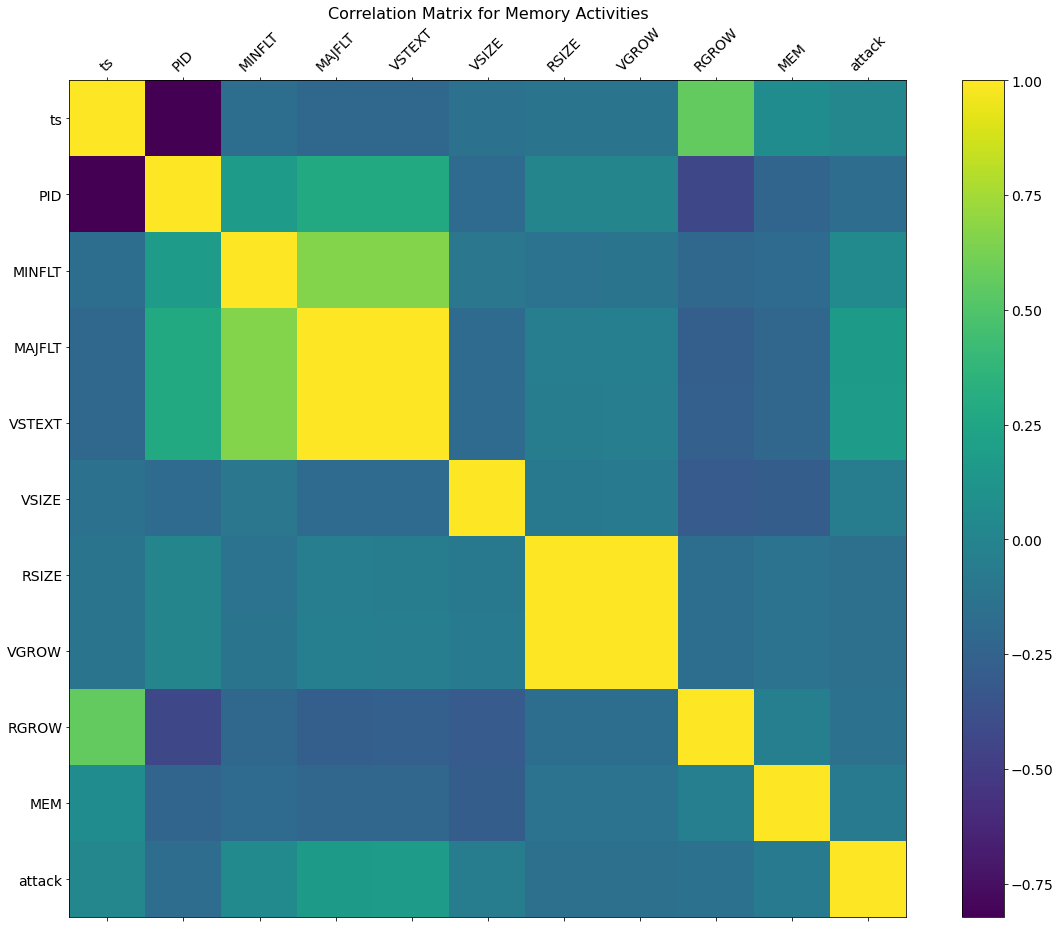

In [26]:
corr_matrix_mem = correlation_matrix(df_memory.select(numericalColMem).fillna(0),numericalColMem)
f = plt.figure(figsize=(20, 15))
plt.matshow(corr_matrix_mem.corr(), fignum=f.number)
plt.xticks(range(corr_matrix_mem.shape[1]), corr_matrix_mem.columns, fontsize=14, rotation=45)
plt.yticks(range(corr_matrix_mem.shape[1]), corr_matrix_mem.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for Memory Activities', fontsize=16)

<p>
We can see that ts and PID have very high correlation with each other and some critical variables. However since ts is nothing but timestamp of the activity and PID is a unique ID, they have an inflated correlation due to the uniqueness of each entry.

We can see some intreseting correlations form the above memory correlation matrix. We can see that VSTEXT and MAJFLT have a highly positive correlation. The most positive correlated features to attack MINFLT, MAJFLT and VSTEXT. 
</p>

### Task 1.3.3 Histogram

In [27]:
undersampledProc = df_process.sample(False,0.2).toPandas()

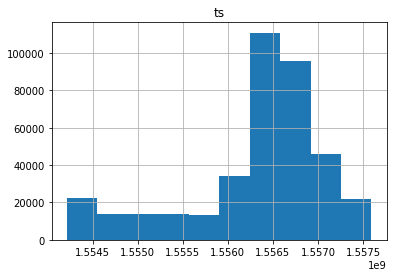

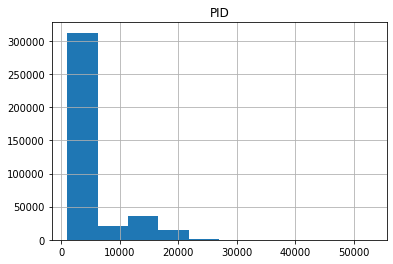

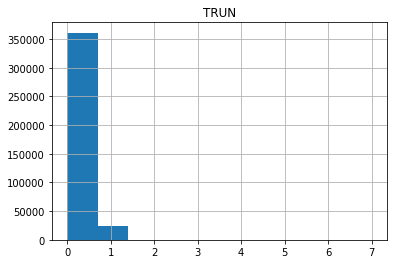

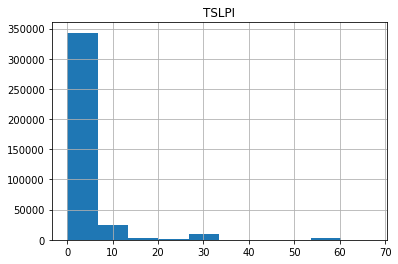

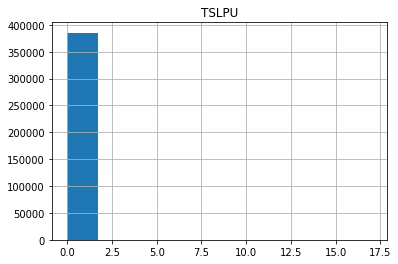

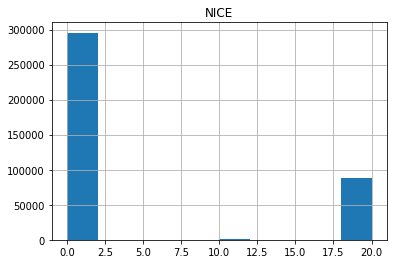

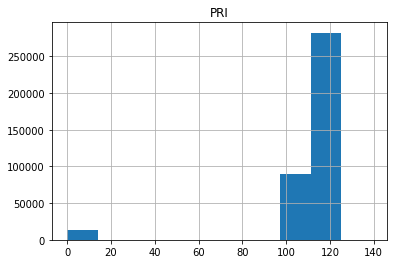

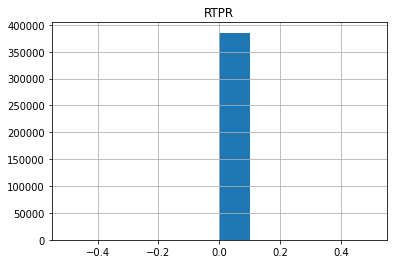

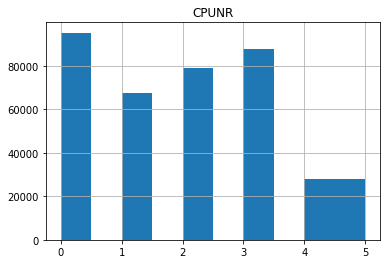

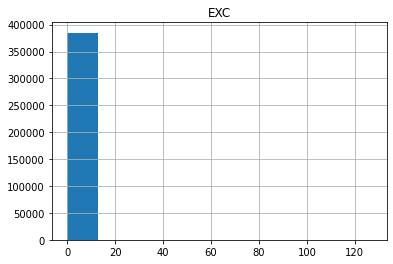

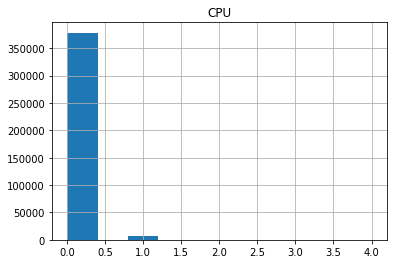

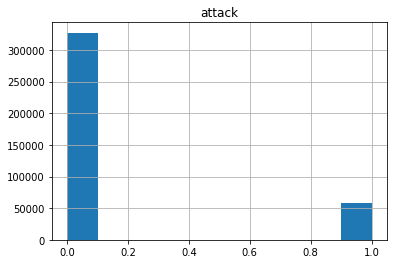

In [28]:
for x in numericalColProc:
    undersampledProc.hist(x)

In [29]:
undersampledMem = df_memory.sample(False,0.2).toPandas()

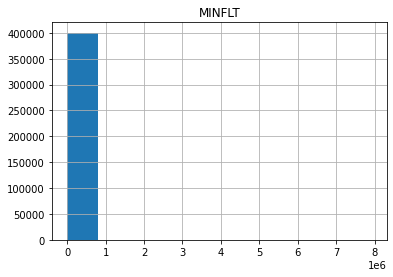

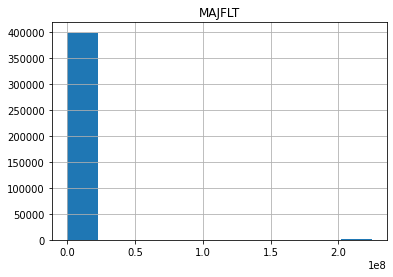

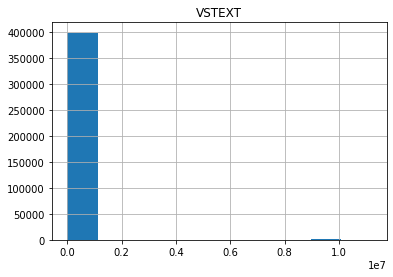

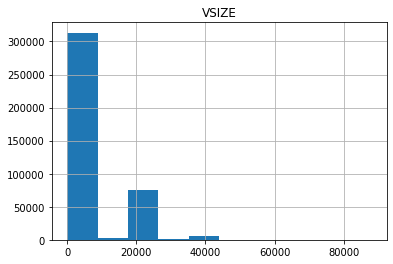

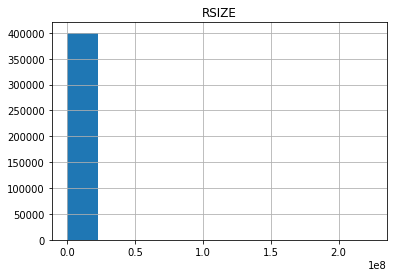

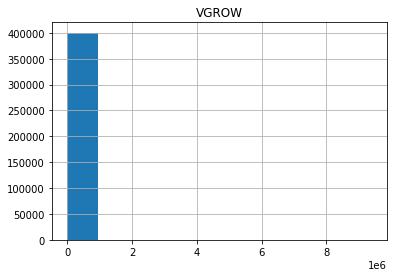

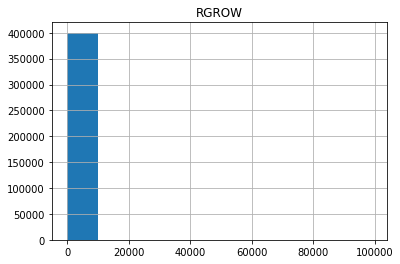

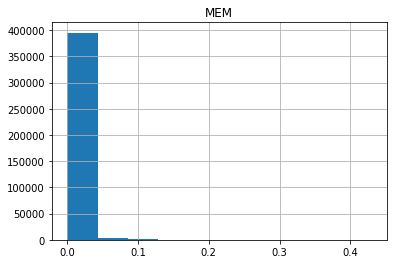

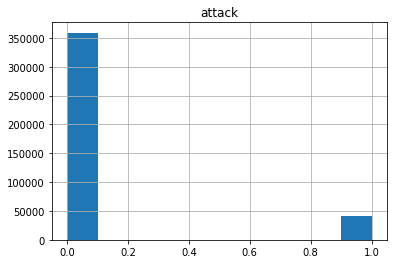

In [62]:
for x in ["MINFLT","MAJFLT","VSTEXT","VSIZE","RSIZE","VGROW","RGROW","MEM","attack"]:
    undersampledMem.hist(x)

# Task 2: Feature extraction and ML training

## Task 2.1 Preparing the train and test data.

In [31]:
#80-20 Rnadom Split
trainMem, testMem = df_memory.randomSplit([0.8,0.2], seed=1234500)
trainProc, testProc = df_process.randomSplit([0.8,0.2], seed=1234500)

### Task 2.1.2 Rebalancing

In [32]:
#filter out attack subset.
memAttack = trainMem.filter(trainMem.attack == 1)
#80-20 random split of onyl attack subset
memAttack80, memAttack20 = memAttack.randomSplit([0.8,0.2], seed=42)
#filter out non attack subset.
memNonAttack = trainMem.filter(trainMem.attack == 0)
#sample from non attack subset
memNonAttackSampled  = memNonAttack.sample(True, 0.045)
#combine our sampled non attack subset with our 20% split attack subset
rebalancedMem = memNonAttackSampled.unionAll(memAttack20)

In [33]:
#filter out attack subset.
procAttack = trainProc.filter(trainProc.attack == 1)
#80-20 random split of onyl attack subset
procAttack80, procAttack20 = procAttack.randomSplit([0.8,0.2], seed=42)
#filter out non attack subset.
procNonAttack = trainProc.filter(trainProc.attack == 0)
#sample from non attack subset
procNonAttackedSampled  = procNonAttack.sample(True, 0.071)
#combine our sampled non attack subset with our 20% split attack subset
rebalancedProc = procNonAttackedSampled.unionAll(procAttack20)

In [34]:
rebalancedMem.cache()
rebalancedProc.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: double, CMD: string, attack: int, type: string]

## Task 2.2 

### Task 2.2.1

<p>
Based on the above exploration for memory activity we can select the following features:
    
    * CMD
    * MINFLT
    * MAJFLT
    * VSTEXT
    * RSIZE
    * RGROW

</p>

<p>
Based on the above exploration for memory activity we can select the following features:
    
    * POLI
    * Status
    * State
    * CMD
    * MINFLT
    * MAJFLT
    * VSTEXT
    * RSIZE
    * RGROW
To transform these features we will be sending them through the StringIndexer and Encoder, we will then use our vector assembler to combine them into the final feature column.  

</p>

<p>
For both the activity we will be following through the same steps to tranform our features. They are
    
* StringIndexer - encodes a string column of labels to a column of label indices.If the input column is numeric, we cast it to string and index the string values.
    
* OneHotEncoder -  maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features, such as Logistic Regression, to use categorical features. For string type input data, it is common to encode categorical features using StringIndexer first.
    
* Vector Assembler - is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector

</p>

### Task 2.2.2

Transformers Estimators for Memory

In [35]:
selectedCatColMem = ["CMD"]
selectedNumColMem = ["MINFLT","MAJFLT","VSTEXT","RSIZE","RGROW"]

#String indexer
inputCols = selectedCatColMem + selectedNumColMem
indexerMem = StringIndexer(inputCols=inputCols, outputCols=[x+"_index" for x in inputCols]).setHandleInvalid("keep")

#OHE encoder
inputCols_OHE = indexerMem.getOutputCols()
encoderMem = OneHotEncoder(inputCols = inputCols_OHE, outputCols = [x+"_vec" for x in inputCols_OHE])

#Assembler
inputCols_Ass = encoderMem.getOutputCols()
assemblerMem = VectorAssembler(inputCols = inputCols_Ass,outputCol='features')

Transformers Estimators for process

In [36]:
selectedCatColProc = ['POLI', 'Status', 'State', 'CMD']
selectedNumColProc = ['TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'CPUNR', 'EXC', 'CPU']

#String indexer
inputCols = selectedCatColProc+selectedNumColProc
indexerProc = StringIndexer(inputCols=inputCols, outputCols=[x+"_index" for x in inputCols]).setHandleInvalid("keep")

#OHE encoder
inputCols_OHE = indexerProc.getOutputCols()
encoderProc = OneHotEncoder(inputCols = inputCols_OHE, outputCols = [x+"_vec" for x in inputCols_OHE])

#Assembler
inputCols_Ass = encoderProc.getOutputCols() + selectedNumColProc
assemblerProc = VectorAssembler(inputCols = inputCols_Ass,outputCol='features')

## Task 2.2.3

### Memory Pipelie

### Decision Tree

In [37]:
dtMem = DecisionTreeClassifier(featuresCol= 'features', labelCol = 'attack', maxDepth = 3)

stages=[indexerMem,encoderMem,assemblerMem,dtMem]

pipelineMemDT = Pipeline(stages = stages)

### Gradient Decision Tree

In [38]:
gbtMem = GBTClassifier(labelCol="attack", featuresCol="features",maxIter=10)

stages=[indexerMem,encoderMem,assemblerMem,gbtMem]

pipelineMemGBT = Pipeline(stages = stages)

### Process Pipeline

### Decision Tree

In [39]:
dtProc = DecisionTreeClassifier(featuresCol= 'features', labelCol = 'attack', maxDepth = 3)

stagesProc=[indexerProc,encoderProc,assemblerProc,dtProc]

pipelineProcDT = Pipeline(stages = stagesProc)

### Gradient Decision Tree

In [40]:
gbtProc = GBTClassifier(labelCol="attack", featuresCol="features",maxIter=10)

stages=[indexerProc,encoderProc,assemblerProc,gbtProc]

pipelineProcGBT = Pipeline(stages = stages)

## Task 2.3

### Task 2.3.1

DT

In [41]:
rebalancedProcDTModel = pipelineProcDT.fit(rebalancedProc)

In [42]:
rebalancedMemDTModel = pipelineMemDT.fit(rebalancedMem)

GBT

In [43]:
rebalancedMemGBTModel = pipelineMemGBT.fit(rebalancedMem)

In [44]:
rebalancedProcGBTModel = pipelineProcGBT.fit(rebalancedProc)

### Task 2.3.2

DT

In [45]:
#Process
rebalancedProcDTTransform = rebalancedProcDTModel.transform(testProc)
rebalancedProcDTTransform.groupBy("attack","prediction").count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 38612|
|     0|       0.0|291327|
|     1|       1.0| 19718|
|     0|       1.0| 35906|
+------+----------+------+



In [46]:
#Memory
rebalancedMemDTTransform = rebalancedMemDTModel.transform(testMem)
rebalancedMemDTTransform.groupBy("attack","prediction").count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       1.0|  2339|
|   0.0|       1.0|  2625|
|   1.0|       0.0| 38728|
|   0.0|       0.0|356399|
+------+----------+------+



GBT

In [47]:
#Process
rebalancedMemGBTTransform = rebalancedMemGBTModel.transform(testMem)
rebalancedMemGBTTransform.groupBy("attack","prediction").count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       1.0|  5770|
|   0.0|       1.0|  7073|
|   1.0|       0.0| 35297|
|   0.0|       0.0|351951|
+------+----------+------+



In [48]:
#Memory
rebalancedProcGBTTransform = rebalancedProcGBTModel.transform(testProc)
rebalancedProcGBTTransform.groupBy("attack","prediction").count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 35859|
|     0|       0.0|290417|
|     1|       1.0| 22471|
|     0|       1.0| 36816|
+------+----------+------+



### Task 2.3.3

In [49]:
# Calculate the elements of the confusion matrix
TN = rebalancedProcDTTransform.filter('prediction = 0 AND attack = 0').count()
TP = rebalancedProcDTTransform.filter('prediction = 1 AND attack = 1').count()
FN = rebalancedProcDTTransform.filter('prediction = 1 AND attack = 0').count()
FP = rebalancedProcDTTransform.filter('prediction = 0 AND attack = 1').count()


# calculate metrics by the confusion matrix
accuracy = (TN+TP)/(TN+TP+FN+FP)#WRITE CODE : formula to find accuracy
precision = TP/(TP+FP)#WRITE CODE : formula to find precision
recall = TP/(TP+FN)#WRITE CODE : formula to find recall
f1 = 2*((precision*recall)/(precision+recall))

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol = 'attack')
auc_dt = evaluator.evaluate(rebalancedProcDTTransform)
print("===Metrics for Rebalanced Process DT Model===")
print("Area under the curve value is %s" % (auc_dt))
print("Accuracy value is %s" % (accuracy))
print("Precision value is %s" % (precision))
print("Recal value is %s" % (recall))
print("F1 Score is %s" % (f1))

===Metrics for Rebalanced Process DT Model===
Area under the curve value is 0.3933182323482265
Accuracy value is 0.8067293801531786
Precision value is 0.33804217383850504
Recal value is 0.35448727168128863
F1 Score is 0.3460694666268845


In [50]:
# Calculate the elements of the confusion matrix
TN = rebalancedMemDTTransform.filter('prediction = 0 AND attack = 0').count()
TP = rebalancedMemDTTransform.filter('prediction = 1 AND attack = 1').count()
FN = rebalancedMemDTTransform.filter('prediction = 1 AND attack = 0').count()
FP = rebalancedMemDTTransform.filter('prediction = 0 AND attack = 1').count()

# calculate metrics by the confusion matrix
accuracy = (TN+TP)/(TN+TP+FN+FP)#WRITE CODE : formula to find accuracy
precision = TP/(TP+FP)#WRITE CODE : formula to find precision
recall = TP/(TP+FN)#WRITE CODE : formula to find recall
f1 = 2*((precision*recall)/(precision+recall))

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol = 'attack')
auc_dt = evaluator.evaluate(rebalancedMemDTTransform)
print("===Metrics for Rebalanced Memory DT Model===")
print("Area under the curve value is %s" % (auc_dt))
print("Accuracy value is %s" % (accuracy))
print("Precision value is %s" % (precision))
print("Recal value is %s" % (recall))
print("F1 Score is %s" % (f1))

===Metrics for Rebalanced Memory DT Model===
Area under the curve value is 0.538589119889532
Accuracy value is 0.8966410141692764
Precision value is 0.056955706528356104
Recal value is 0.47119258662369057
F1 Score is 0.10162716430231801


In [51]:
# Calculate the elements of the confusion matrix
TN = rebalancedMemGBTTransform.filter('prediction = 0 AND attack = 0').count()
TP = rebalancedMemGBTTransform.filter('prediction = 1 AND attack = 1').count()
FN = rebalancedMemGBTTransform.filter('prediction = 1 AND attack = 0').count()
FP = rebalancedMemGBTTransform.filter('prediction = 0 AND attack = 1').count()

# calculate metrics by the confusion matrix
accuracy = (TN+TP)/(TN+TP+FN+FP)#WRITE CODE : formula to find accuracy
precision = TP/(TP+FP)#WRITE CODE : formula to find precision
recall = TP/(TP+FN)#WRITE CODE : formula to find recall
f1 = 2*((precision*recall)/(precision+recall))

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol = 'attack')
auc_dt = evaluator.evaluate(rebalancedMemGBTTransform)
print("===Metrics for Rebalanced Memory GBT Model===")
print("Area under the curve value is %s" % (auc_dt))
print("Accuracy value is %s" % (accuracy))
print("Precision value is %s" % (precision))
print("Recal value is %s" % (recall))
print("F1 Score is %s" % (f1))

===Metrics for Rebalanced Memory GBT Model===
Area under the curve value is 0.7450339605418375
Accuracy value is 0.8940990924564661
Precision value is 0.14050210631407212
Recal value is 0.44927197695242543
F1 Score is 0.21406047115562976


In [52]:
# Calculate the elements of the confusion matrix
TN = rebalancedProcGBTTransform.filter('prediction = 0 AND attack = 0').count()
TP = rebalancedProcGBTTransform.filter('prediction = 1 AND attack = 1').count()
FN = rebalancedProcGBTTransform.filter('prediction = 1 AND attack = 0').count()
FP = rebalancedProcGBTTransform.filter('prediction = 0 AND attack = 1').count()

# calculate metrics by the confusion matrix
accuracy = (TN+TP)/(TN+TP+FN+FP)#WRITE CODE : formula to find accuracy
precision = TP/(TP+FP)#WRITE CODE : formula to find precision
recall = TP/(TP+FN)#WRITE CODE : formula to find recall
f1 = 2*((precision*recall)/(precision+recall))

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol = 'attack')
auc_dt = evaluator.evaluate(rebalancedProcGBTTransform)
print("===Metrics for Rebalanced Process GBT Model===")
print("Area under the curve value is %s" % (auc_dt))
print("Accuracy value is %s" % (accuracy))
print("Precision value is %s" % (precision))
print("Recal value is %s" % (recall))
print("F1 Score is %s" % (f1))

===Metrics for Rebalanced Process GBT Model===
Area under the curve value is 0.7441320892323479
Accuracy value is 0.811509403132562
Precision value is 0.3852391565232299
Recal value is 0.3790206959367146
F1 Score is 0.3821046277323856


<p>
Our best metric to judge the validity of our model should be the AUC-ROC value.
    
AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.
</p>

### Task 2.3.4

<p>
Top 5 features for Mem Pipeline(DT & GBT) -"MINFLT","MAJFLT","VSTEXT","RSIZE","CMD"  
    
Top 5 features for Process Pipelines(DT & GBT) - "NICE" ,"CPU", "TRUN", "CMD", "TSLPU"
     
Our Gradient Boosted Tree pipeline model is better than our Decision Tree pipeline. While in DT one a single decision tree is trainined, in GBT multiple tree are trainined one by one and then from these decision trees, the best one is selected.   
    
The features 'ts' and 'PID' should not be selected as features for our models. If we see the meta data of our files, we see that ts is a timestamp and PID is a unique id for each process. If these features are included our models will overfit on these columns and we will get an artificially inflated accuracy. Which will fail on unseen data.</p>

### Task 2.3.5

In [53]:
#Get dataset in 1:2 attacking:non-attacking 
TempMemNonAttackSampled  = memNonAttack.sample(True, 0.22)
#union with dataframe which was filtered for only attack.
upscaledMemNonAttack = TempMemNonAttackSampled.unionAll(memAttack)
upscaledMemNonAttack.groupBy("attack").count().show()

+------+------+
|attack| count|
+------+------+
|   0.0|316167|
|   1.0|164556|
+------+------+



In [54]:
#Get dataset in 1:2 attacking:non-attacking 
tempProcNonAttack = procNonAttack.sample(True, 0.35)
#union with dataframe which was filtered for only attack.
upscaledProcNonAttack = tempProcNonAttack.unionAll(procAttack)
upscaledProcNonAttack.groupBy("attack").count().show()

+------+------+
|attack| count|
+------+------+
|     1|233034|
|     0|457795|
+------+------+



In [55]:
#Split 1:2 balanced dataset into test and train
upscaledTrainMem, upscaledTestMem = upscaledMemNonAttack.randomSplit([0.8,0.2], seed=1234500) 
upscaledTrainProc, upscaledTestProc = upscaledProcNonAttack.randomSplit([0.8,0.2], seed=1234500) 

DT

In [56]:
#Upscaled Mem Model
upscaledMemDTModel = pipelineMemDT.fit(upscaledTrainMem)
upscaledMemDTTransform = upscaledMemDTModel.transform(upscaledTestMem)
upscaledMemDTTransform.groupBy("attack","prediction").count().show()

+------+----------+-----+
|attack|prediction|count|
+------+----------+-----+
|   1.0|       1.0| 1835|
|   0.0|       1.0|  455|
|   1.0|       0.0|31046|
|   0.0|       0.0|62839|
+------+----------+-----+



In [57]:
#Upscaled Proc Model
upscaledProcDTModel = pipelineProcDT.fit(upscaledTrainProc)
upscaledProcDTTransform = upscaledProcDTModel.transform(upscaledTestProc)
upscaledProcDTTransform.groupBy("attack","prediction").count().show()

+------+----------+-----+
|attack|prediction|count|
+------+----------+-----+
|     1|       0.0|31015|
|     0|       0.0|81785|
|     1|       1.0|15615|
|     0|       1.0| 9894|
+------+----------+-----+



GBT

In [58]:
#GBT Process upscaled
upscaledProcGBTModel = pipelineProcGBT.fit(upscaledTrainProc)
upscaledProcGBTTransformed = upscaledProcGBTModel.transform(upscaledTestProc)
upscaledProcGBTTransformed.groupBy("attack","prediction").count().show()

+------+----------+-----+
|attack|prediction|count|
+------+----------+-----+
|     1|       0.0|28322|
|     0|       0.0|80832|
|     1|       1.0|18308|
|     0|       1.0|10847|
+------+----------+-----+



In [59]:
#GBT Mem upsacled
upscaledMemGBTModel = pipelineMemGBT.fit(upscaledTrainMem)
upscaledGBTTransformed = upscaledMemGBTModel.transform(upscaledTestMem)
upscaledGBTTransformed.groupBy("attack","prediction").count().show()

+------+----------+-----+
|attack|prediction|count|
+------+----------+-----+
|   1.0|       1.0| 4936|
|   0.0|       1.0| 1028|
|   1.0|       0.0|27945|
|   0.0|       0.0|62266|
+------+----------+-----+



In [60]:
#Cache the new 1:2 balanced dataset
upscaledGBTTransformed.cache()
upscaledProcGBTTransformed.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: double, CMD: string, attack: int, type: string, TSLPU_index: double, TSLPI_index: double, POLI_index: double, State_index: double, Status_index: double, CPU_index: double, CPUNR_index: double, EXC_index: double, CMD_index: double, TRUN_index: double, PRI_index: double, NICE_index: double, State_index_vec: vector, NICE_index_vec: vector, PRI_index_vec: vector, TSLPU_index_vec: vector, CPU_index_vec: vector, TSLPI_index_vec: vector, CPUNR_index_vec: vector, TRUN_index_vec: vector, POLI_index_vec: vector, EXC_index_vec: vector, CMD_index_vec: vector, Status_index_vec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

# Task 3: Knowledge Sharing regarding KMeans Clustering

In [61]:
iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

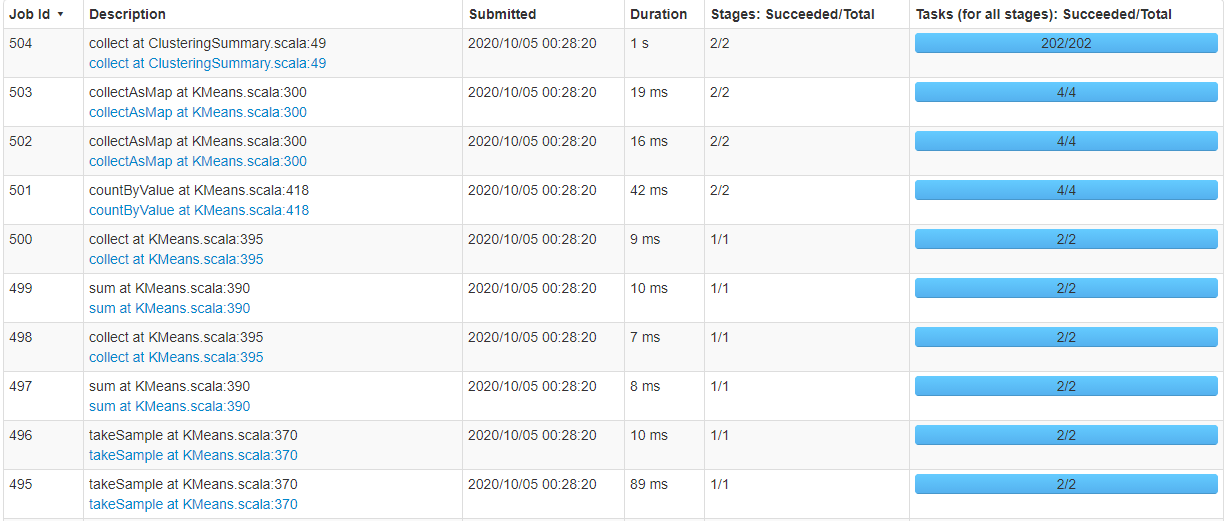

<p>
From the above image we can see on running the code, 10 jobs are executed. The jobs are executed in the seq of id 495-504.

Following are what each jobs is doing:
    
* <b>takeSample at Kmeans.scala:370</b> -  Initialize a set of cluster centers using the k-means. This jobs takes a smaller sample from the given dataset and parallizes it for working with pyspark.
    
* <b>sum at Kmeans.scala:390</b> -On each step, sample 2 * k points on average with probability proportional to their squared distance from the centers. Note that only distances between points and new centers are computed in each iteration.
    
* <b>collect at Kmeans.scala:395</b>  - Collected the data for futther transformation and calculation
    
* <b>countByValue at Kmeans.scala:418</b> - Finally, we might have a set of more than k distinct candidate centers; weight each candidate by the number of points in the dataset mapping to it and run a local k-means++ on the weighted centers to pick k of them.
    
* <b>collectAsMap at Kmeans.scala:300</b> - Calculates and tabulates the cluester weights, reduces by key and collectasMap.
    
* <b>collect at ClusteringSummary.scala:49</b> - we zip the data according to cost, then XORshift is randomly, after filtering out according to point cost we collect our result.
    
</p>